In [30]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [31]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Load the Drive helper and mount

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Data Preprocessing**

In [32]:
full_df = []
for item in os.listdir('./data')[:10]:
  csv_path = './data/'+item
  print(csv_path)
  df = pd.read_csv(csv_path)
  full_df.append(df)
df_full = pd.concat(full_df)
len(full_df)

./data/test_cleaned.csv


1

In [33]:
train_full = []
val_full = []
test_full = []

for df in full_df:
  cols = ['Datetime','CSSR',	'USER_DL_AVG_THPUT'	,'USER_UL_AVG_THPUT','DL_LATENCY'	,'TRAFFIC','INTRA_FREQUENCY_HO', 'SERVICE_DROP_ALL'] #'UL_LATENCY'
  df = df[cols]
  date_time = pd.to_datetime(df.pop('Datetime'), format='%Y-%m-%d %H:%M:%S')
  df = df.rename(columns={'CSSR':'cssr',	'USER_DL_AVG_THPUT':'user_dl_avg_thput'	,'USER_UL_AVG_THPUT':'user_ul_avg_thput','DL_LATENCY':'dl_latency'	,'TRAFFIC':'traffic','INTRA_FREQUENCY_HO':'intra_frequency_ho', 'SERVICE_DROP_ALL' :'service_drop_all'})
  
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  day = 24*60*60
  year = (365.2425)*day

#Xóa bỏ các thời gian trong ngày và trong năm
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]

  train_full.append(train_df)
  val_full.append(val_df)
  test_full.append(test_df)

In [34]:
#Chia theo tỷ lệ 70:20:10
print("Số quan sát trên tập train: ",len(train_full[0]))
print("Số quan sát trên tập val: ",len(val_full[0]))
print("Số quan sát trên tập test: ",len(test_full[0]))

Số quan sát trên tập train:  5124
Số quan sát trên tập val:  1464
Số quan sát trên tập test:  732


In [35]:
train_full_df = pd.concat(train_full)
train_mean = train_full_df.mean()
train_std = train_full_df.std()

In [36]:
#Chuẩn hóa dữ liệu
for index in range (len(train_full)):
  train_full[index] = (train_full[index] - train_mean) / train_std
  val_full[index] = (val_full[index] - train_mean) / train_std
  test_full[index] = (test_full[index] - train_mean) / train_std

**Labeling**

In [37]:
column_indices = {name: i for i, name in enumerate(train_full[0].columns)}

num_features = train_full[0].shape[1]

In [38]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    # self.train_df = train_df
    # self.val_df = val_df
    # self.test_df = test_df

    self.train_df = train_full
    self.val_df = val_full
    self.test_df = test_full

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='user_ul_avg_thput', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, dataset):
    ds_dataset = None
    for data in dataset:
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)
      if ds_dataset is None:
        ds_dataset = ds
      else:
        ds_dataset = ds_dataset.concatenate(ds)
    return ds_dataset

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

**Train and Evaluation**

In [39]:
MAX_EPOCHS = 40
#set hàm train model
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.00005),
                metrics=[tf.metrics.MeanAbsoluteError()])
  # model.compile(loss='qps',
  #               optimizer=tf.optimizers.Adam(learning_rate = 0.00005),
  #               metrics=['mse'])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val) #callbacks=[early_stopping]
  return history

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

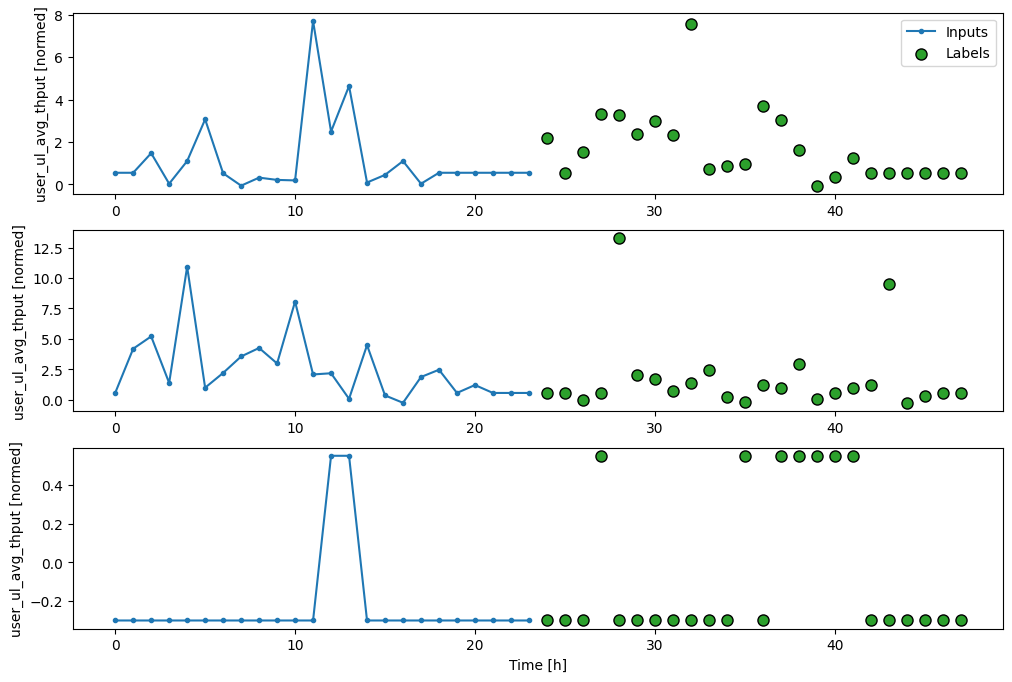

In [40]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)
# multi_window = WindowGenerator(input_width=24,
#                                label_width=1,
#                                shift=OUT_STEPS)
multi_window.plot()
multi_window

In [41]:
multi_val_performance = {}
multi_performance = {}

**LSTM**

22/22 [==============================] - 0s 5ms/step - loss: 1.1901 - mean_absolute_error: 0.5400


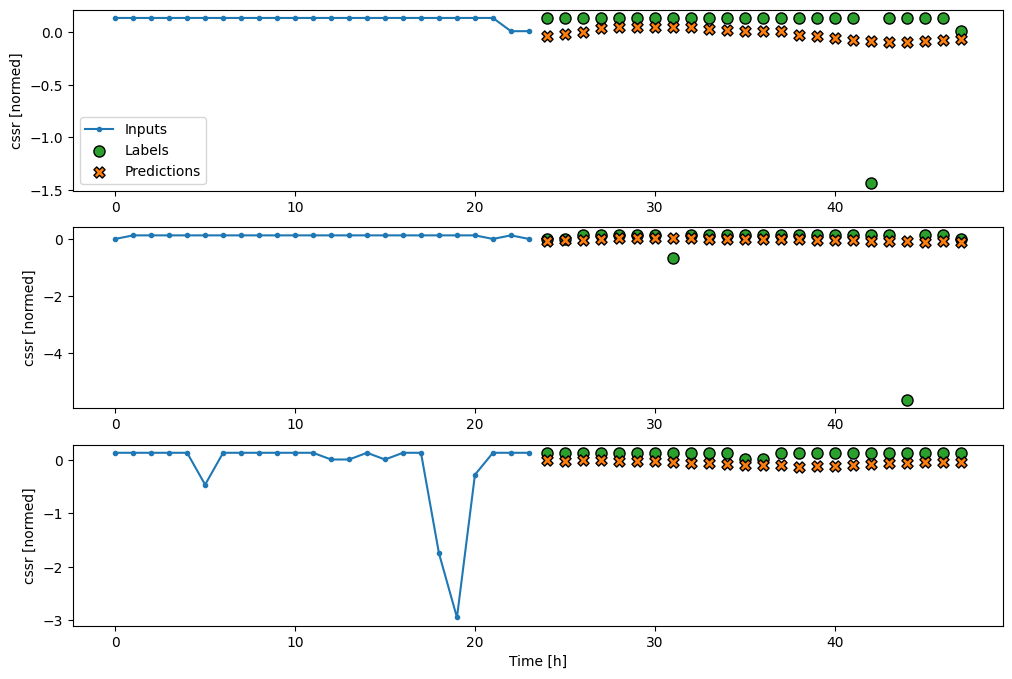

In [42]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)
multi_window.plot(multi_lstm_model, plot_col='cssr')
#biểu đồ 3 cửa sổ ví dụ thể hiện giá trị dự đoán trên tập test so với label

In [43]:
# loss: 0.7802 - mean_absolute_error: 0.4548 - val_loss: 1.5811 - val_mean_absolute_error
his = history.history
train_loss = his['loss']
train_mae = his['mean_absolute_error']
# train_mae = his['mse']
val_loss = his['val_loss']
val_mae = his['val_mean_absolute_error']
# val_mae = his['val_mse']

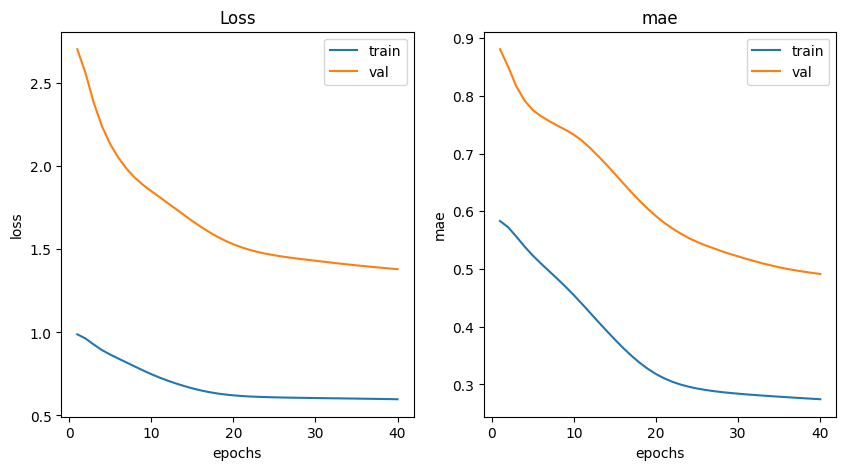

In [44]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, MAX_EPOCHS+1), train_loss, label='train')
plt.plot(range(1, MAX_EPOCHS+1), val_loss, label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(122)
plt.plot(range(1, MAX_EPOCHS+1), train_mae, label='train')
plt.plot(range(1, MAX_EPOCHS+1), val_mae, label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('mae')
plt.title('mae')
#Biểu đồ giá trị hàm mất mát và hàm đánh giá mô hình của tập validation so với tập train
plt.show()

In [45]:
x = np.arange(1)
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()] 
test_mae = [v[metric_index] for v in multi_performance.values()]
val = []
val.append(val_mae[0])
test = []
test.append(test_mae[0])
plt.bar(x - 0.17, val, width, label='Validation')
plt.bar(x + 0.17, test, width, label='Test')
plt.xticks(ticks=x, labels=["LSTM"],
           rotation=45)
print("Gía trị MAE trên tập validation: ",val_mae[0])
print("Gía trị MAE trên tập test: ",test_mae[0])
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

NameError: name 'feedback_model' is not defined

**AR LSTM**

In [ ]:
# class FeedBack(tf.keras.Model):
#   def __init__(self, units, out_steps):
#     super().__init__()
#     self.out_steps = out_steps
#     self.units = units
#     self.lstm_cell = tf.keras.layers.LSTMCell(units)
#     # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
#     self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
#     self.dense = tf.keras.layers.Dense(num_features)

# feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

# def warmup(self, inputs):
#   # inputs.shape => (batch, time, features)
#   # x.shape => (batch, lstm_units)
#   x, *state = self.lstm_rnn(inputs)

#   # predictions.shape => (batch, features)
#   prediction = self.dense(x)
#   return prediction, state

# FeedBack.warmup = warmup

# prediction, state = feedback_model.warmup(multi_window.example[0])
# prediction.shape

# def call(self, inputs, training=None):
#   # Use a TensorArray to capture dynamically unrolled outputs.
#   predictions = []
#   # Initialize the LSTM state.
#   prediction, state = self.warmup(inputs)

#   # Insert the first prediction.
#   predictions.append(prediction)

#   # Run the rest of the prediction steps.
#   for n in range(1, self.out_steps):
#     # Use the last prediction as input.
#     x = prediction
#     # Execute one lstm step.
#     x, state = self.lstm_cell(x, states=state,
#                               training=training)
#     # Convert the lstm output to a prediction.
#     prediction = self.dense(x)
#     # Add the prediction to the output.
#     predictions.append(prediction)

#   # predictions.shape => (time, batch, features)
#   predictions = tf.stack(predictions)
#   # predictions.shape => (batch, time, features)
#   predictions = tf.transpose(predictions, [1, 0, 2])
#   return predictions

# FeedBack.call = call

45/45 [==============================] - 1s 10ms/step - loss: 1.4428 - mean_absolute_error: 0.5455


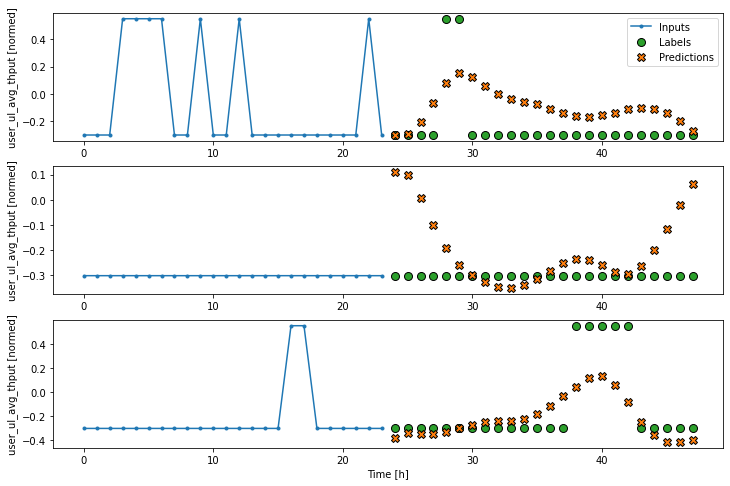

In [ ]:
# history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
# multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(feedback_model)

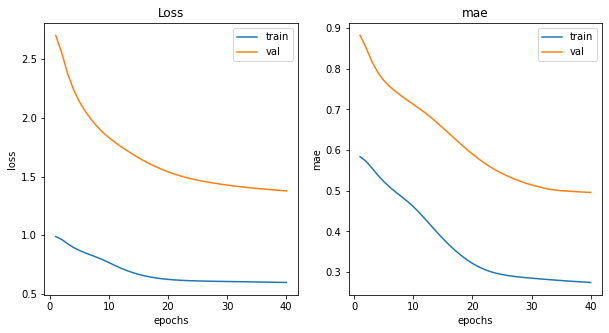

In [ ]:
# %matplotlib inline
# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# plt.plot(range(1, MAX_EPOCHS+1), train_loss, label='train')
# plt.plot(range(1, MAX_EPOCHS+1), val_loss, label='val')
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.title('Loss')

# plt.subplot(122)
# plt.plot(range(1, MAX_EPOCHS+1), train_mae, label='train')
# plt.plot(range(1, MAX_EPOCHS+1), val_mae, label='val')
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('mae')
# plt.title('mae')

# plt.show()

**Residual LSTM**

In [ ]:
# class ResidualWrapper(tf.keras.Model):
#   def __init__(self, model):
#     super().__init__()
#     self.model = model

#   def call(self, inputs, *args, **kwargs):
#     delta = self.model(inputs, *args, **kwargs)

#     # The prediction for each time step is the input
#     # from the previous time step plus the delta
#     # calculated by the model.
#     return inputs + delta

45/45 [==============================] - 0s 4ms/step - loss: 2.2481 - mean_absolute_error: 0.4592


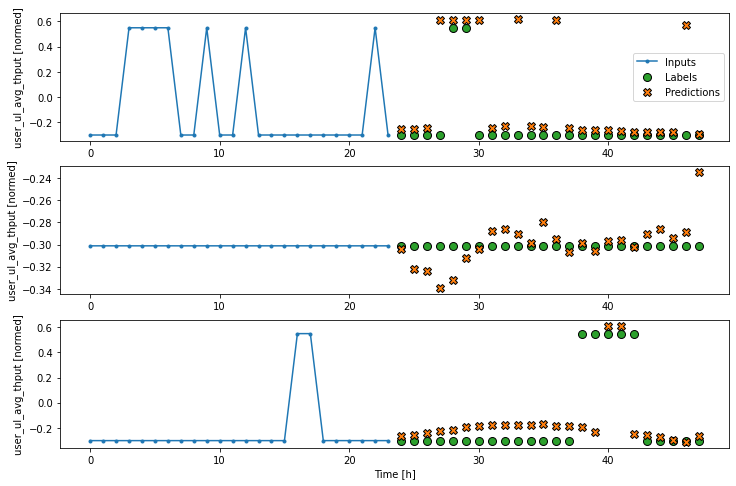

In [ ]:
# residual_multi_lstm_model = ResidualWrapper(
#     tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, lstm_units].
#     # Adding more `lstm_units` just overfits more quickly.
#     tf.keras.layers.LSTM(32, return_sequences=False),
#     # Shape => [batch, out_steps*features].
#     tf.keras.layers.Dense(OUT_STEPS*num_features,
#                           kernel_initializer=tf.initializers.zeros()),
#     # Shape => [batch, out_steps, features].
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ]))

# history = compile_and_fit(residual_multi_lstm_model, multi_window)

# IPython.display.clear_output()
# multi_val_performance['Residual LSTM'] = residual_multi_lstm_model.evaluate(multi_window.val)
# multi_performance['Residual LSTM'] = residual_multi_lstm_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(residual_multi_lstm_model)

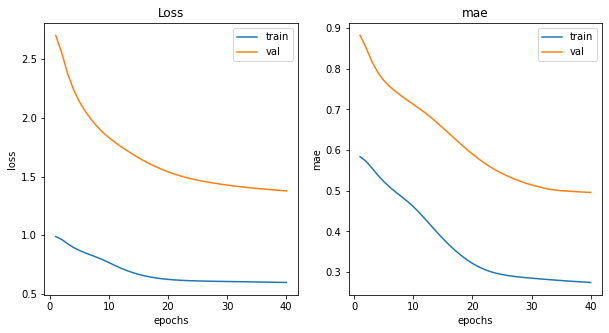

In [ ]:
# %matplotlib inline
# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# plt.plot(range(1, MAX_EPOCHS+1), train_loss, label='train')
# plt.plot(range(1, MAX_EPOCHS+1), val_loss, label='val')
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.title('Loss')

# plt.subplot(122)
# plt.plot(range(1, MAX_EPOCHS+1), train_mae, label='train')
# plt.plot(range(1, MAX_EPOCHS+1), val_mae, label='val')
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('mae')
# plt.title('mae')

# plt.show()

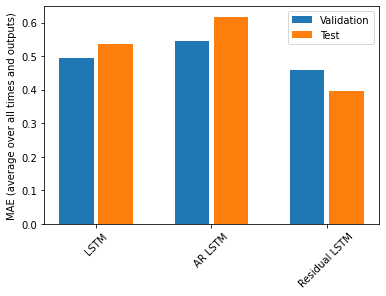

In [ ]:
# x = np.arange(len(multi_performance))
# width = 0.3
# metric_name = 'mean_absolute_error'
# metric_index = feedback_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in multi_val_performance.values()] 
# test_mae = [v[metric_index] for v in multi_performance.values()]
# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=multi_performance.keys(),
#            rotation=45)
# plt.ylabel(f'MAE (average over all times and outputs)')
# _ = plt.legend()